In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import c
from mc_sspals import initialize, convert
from mc_sspals.laser import Laser, Transition, fluence, doppler, overlap
import seaborn as sns                                       # statistics/ plotting
sns.set(style="ticks", font_scale=1.25)

In [3]:
# positrons
num = int(1e6)
sigma_x = 1e-3
sigma_t = 2e-9
# converter
eff = 0.25
T = 400
# Lyman-alpha
lyman_alpha = Transition(wavelength=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
threshold = 0.002
uv = Laser(energy=0.001, wavelength=2.43e-7, bandwidth=85e9, retro=False,
           distance=0.0005, height=0.006, width=0.0025, trigger=15e-9, sigma_t=3e-9)

In [4]:
df = initialize(num, sigma_t=sigma_t, sigma_x=sigma_x)
df = convert(df, eff=eff, T=T)
df.head()

,status,lifetime,ti,xi,yi,zi,vx,vy,vz
0,e+,0.0,4.465627e-10,0.000089,0.000378,0.0,NaN,NaN,NaN
1,e+,0.0,-2.316290e-09,0.001437,0.000840,0.0,NaN,NaN,NaN
2,e+,0.0,-1.528803e-09,0.000354,-0.000003,0.0,NaN,NaN,NaN
3,e+,0.0,-1.115698e-09,0.000514,-0.000726,0.0,NaN,NaN,NaN
4,e+,0.0,-5.883085e-10,-0.000468,-0.000328,0.0,NaN,NaN,NaN


In [5]:
flu = fluence(df, uv)
dop = doppler(df, uv, lyman_alpha)
ol = overlap(df, uv, lyman_alpha)

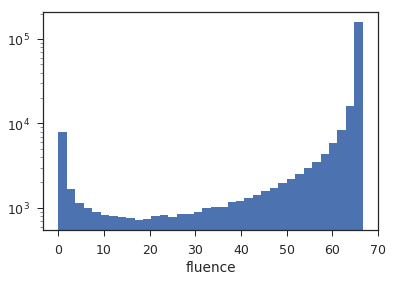

In [6]:
fig, ax = plt.subplots()
ax.hist(flu, 36)
ax.set_xlabel('fluence')
ax.set_yscale('log')
plt.show()

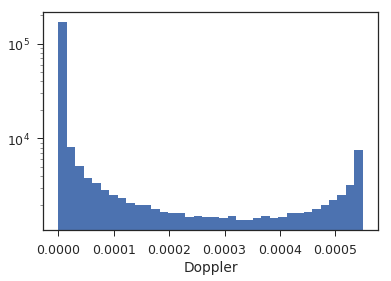

In [7]:
fig, ax = plt.subplots()
ax.hist(dop, 36)
ax.set_xlabel('Doppler')
ax.set_yscale('log')
plt.show()

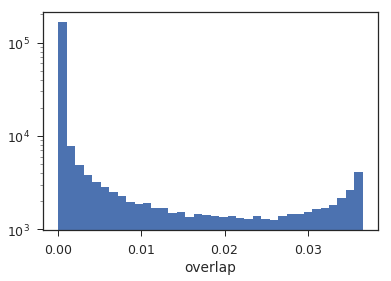

In [8]:
fig, ax = plt.subplots()
ax.hist(ol, 36)
ax.set_xlabel('overlap')
ax.set_yscale('log')
plt.show()

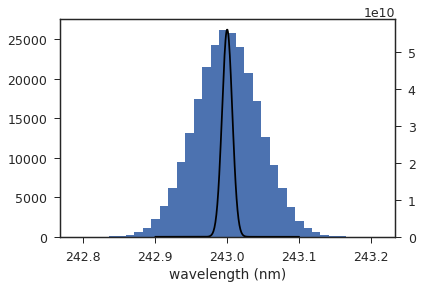

In [9]:
fig, ax1 = plt.subplots()

# MC doppler
dop = (lyman_alpha.wavelength * (1.0 - df.vx / c))
ax1.hist(dop.dropna() * 1e9, 36)
wl = np.linspace(242.9, 243.1, 300) * 1e-9

# laser
ax2 = ax1.twinx()
ax2.plot(wl*1e9, uv.lineshape(wl), label='laser', c='k')

# format
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.set_xlabel('wavelength (nm)')
plt.show()

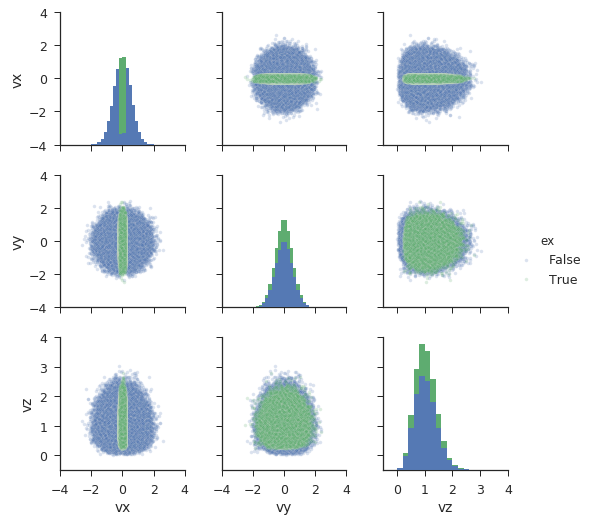

In [10]:
atoms = df[df.status != 'e+']
atoms = atoms.join(ol)
threshold = 0.003
atoms['ex'] = (atoms['overlap'] > threshold).astype(str)
atoms[['vx', 'vy', 'vz']] = atoms[['vx', 'vy', 'vz']] *1e-5

# plot
bins = np.linspace(-4, 4, 41)
g = sns.pairplot(atoms, vars=['vx', 'vy', 'vz'], hue="ex", markers=['.', '.'],
                 plot_kws=dict(alpha=0.2, rasterized=True),
                 diag_kws=dict(alpha=0.95, bins=bins))

for ax in [g.axes[0, 0], g.axes[1, 1]]:
    ax.set_xlim(-4, 4)
    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_ylim(-4, 4)
    ax.set_yticks([-4, -2, 0, 2, 4])

g.axes[2, 2].set_xlim(-0.5, 4)
g.axes[2, 2].set_xticks([0, 1, 2, 3, 4])
g.axes[2, 2].set_ylim(-0.5, 4)
g.axes[2, 2].set_yticks([0, 1, 2, 3, 4])
# output
plt.savefig("../images/mc_vel.pdf", dpi=200, bbox_inches='tight')
plt.show()